In [52]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data

In [53]:
from helpers import load_data

path_dataset = "../Data/data_train.csv"
ratings = load_data(path_dataset).T # ratings: row = user, column = item

number of items: 10000, number of users: 1000


### Plot the number of ratings per movie and user

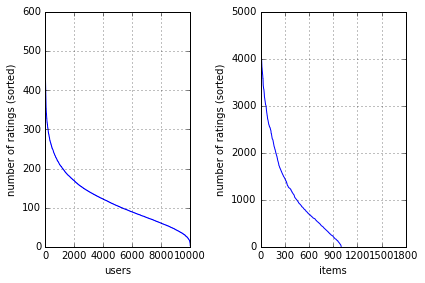

min # of items per user = 3, min # of users per item = 8.


In [54]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [55]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    
    num_items, num_users = valid_ratings.shape 
    
    # create indices
    index_split = int(np.floor((1 - p_test) * num_items))
    indices = np.random.permutation(num_items)
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    
    # create split
    
    train = valid_ratings[index_tr]
    test = valid_ratings[index_te] 
    
    train_full = ratings[index_tr]
    test_full = ratings[index_te] 
        
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    
    return valid_ratings, train, test, valid_users, valid_items, train_full, test_full

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1175189
Total number of nonzero elements in test data:0


/home/chris/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


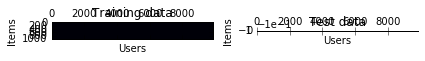

In [56]:
from plots import plot_train_test_data

valid_ratings, train, test, valid_users, valid_items, train_full, test_full = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=20, p_test=0)
plot_train_test_data(train, test)

## Implementation

#### Initialize matrix factorization

In [57]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    # initalization
    num_items, num_users = train.shape
    item_features = np.random.randn(num_features, num_items)
    user_features = np.random.randn(num_features, num_users)
    
    # mean of for each item
    sums_train = train.sum(axis=1).reshape(num_items,)
    counts_train = np.diff(train.tocsr().indptr) # counts number of non zero value for each row
    mean_train_item = sums_train / counts_train
    
    item_features[0,:] = mean_train_item
    
    return user_features, item_features 

#### Cost function (RMSE)

In [58]:
from helpers import calculate_mse

def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""

    # initalization
    prediction = (item_features.T).dot(user_features)
    x, y = zip(*nz)
    
    # remove zero elements
    prediction_nz = prediction[x,y]
    data_nz = data[x,y]
        
    # rmse    
    return np.sqrt(calculate_mse(data_nz, prediction_nz).sum() / (data.nnz))

### Learn the Matrix Factorization using SGD

In [59]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 5     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
        
            e_dn = train[d,n] - (item_features[:,d].T).dot(user_features[:,n])
            grad_user = e_dn * item_features[:, d] - lambda_user * user_features[:, n]
            grad_item =  (e_dn * user_features[:, n] - lambda_item * item_features[:, d])
            
            item_features[:, d] = item_features[:, d] + gamma * grad_item
            user_features[:, n] = user_features[:, n] + gamma * grad_user           
                
                
        regularized_term = lambda_user / 2 * np.linalg.norm(user_features) + lambda_item / 2 * np.linalg.norm(item_features)    
        rmse = compute_error(train, user_features, item_features, nz_train) 

        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)
    
    
    print("TEST")

    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))   

    return user_features, item_features

In [60]:
#predicted_user_features, predicted_item_features = matrix_factorization_SGD(train, test) 

### Learn the Matrix Factorization using Alternating Least Squares

In [61]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    
    I = np.eye(item_features.shape[0])
    item_features_nz = item_features[:, nz_user_itemindices]
    train_nz = train[nz_user_itemindices]
    
    Ai = item_features_nz @ item_features_nz.T + lambda_user * I * nnz_items_per_user
    Vi = item_features_nz @ train_nz

    updated_user_features = np.linalg.solve(Ai,Vi)
        
    return updated_user_features.reshape(item_features.shape[0],), Vi
    

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    
    I = np.eye(user_features.shape[0])
    user_features_nz = user_features[:, nz_item_userindices]
    train_nz = train[:, nz_item_userindices]
    
    Ai = user_features_nz @ user_features_nz.T + lambda_item * I * nnz_users_per_item
    Vi = user_features_nz @ train_nz.T
    
    updated_item_features = np.linalg.solve(Ai,Vi)
    
    return updated_item_features.reshape(user_features.shape[0],), Vi
    

In [64]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.065
    lambda_item = 0.065
    stop_criterion = 1e-3
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    error_list[0] = 1000
    
    # Calculate arguments for the update of Z and W
    nnz_items_per_user = train.getnnz(axis=0)
    nnz_users_per_item = train.getnnz(axis=1)
    nz_train, nz_row_colindices, nz_col_rowindices = build_index_groups(train)   
    
    while (abs(error_list[0] - error_list[1]) > stop_criterion):
                
        # Fix W (item), estimate Z (user)
        for i, nz_user_itemindices in nz_col_rowindices:
            user_features[:,i], test = update_user_feature(train[:,i], item_features, lambda_user, nnz_items_per_user[i], nz_user_itemindices)

        # Fix Z, estimate W
        for j, nz_item_userindices in nz_row_colindices:
            item_features[:,j], essai = update_item_feature(train[j], user_features, lambda_item, nnz_users_per_item[j], nz_item_userindices)
        
        nz_row, nz_col = train.nonzero()
        nz_train = list(zip(nz_row, nz_col))
        error_list[change] = compute_error(train, user_features, item_features, nz_train)
    
        print("RMSE on train data: {}".format(error_list[change]))
    
        if(change == 1):
            change = 0
        else:
            change = 1
        
    print("Converged")
    
    #print("TEST")
    #nz_row_te, nz_col_te = test.nonzero()
    #nz_test = list(zip(nz_row_te, nz_col_te))
    #rmse = compute_error(test, user_features, item_features, nz_test)
    #print("RMSE on test data: {}.".format(rmse)) 
    
    return user_features, item_features

In [65]:
predicted_user_features, predicted_item_features = ALS(train, test)

RMSE on train data: 1.002014441981339
RMSE on train data: 0.9602813325416034
RMSE on train data: 0.9249201764667132
RMSE on train data: 0.9099639960176178
RMSE on train data: 0.902226855808995
RMSE on train data: 0.8972184690164545
RMSE on train data: 0.8936492924626628
RMSE on train data: 0.8909672627289607
RMSE on train data: 0.8888795586858734
RMSE on train data: 0.8872124749681192
RMSE on train data: 0.8858551381214782
RMSE on train data: 0.8847329091849512
RMSE on train data: 0.8837933754883492
Converged


## Post-processing

In [66]:
def add_removed_elements(features, valid_indices, num_elements):
    """Add removed users or items by replacing it with the mean"""
    
    full_features = np.zeros((features.shape[0], num_elements)) + np.mean(features, axis=1).reshape((-1,1))
    for i, Vi in enumerate(valid_indices):
        full_features[:, Vi] = features[:, i]
        
    return full_features


def unvalid_indexes(total_elements, valid_indices):
    """ Return the corresponding unvalid elements indices. If we remove the elements of 
                valid_indices in a data set of size total_elements"""
    
    return np.delete(range(total_elements),valid_indices)



def fill_added_user_features(full_item_features,full_user_features,users_idx_to_calculate,train_full,
                             lambda_user, nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix for a specific set of indices"""
    
    num_users = train_full.shape[1]
    K = full_item_features.shape[0]
    
    # Calculate usin full_item_features or item_features ?
    
    for n in users_idx_to_calculate:
        nz_item_features_per_user = full_item_features[:, nz_user_itemindices[n]]
        A = nz_item_features_per_user @ nz_item_features_per_user.T + nnz_items_per_user[n] * lambda_user*np.eye(K)
        ratings_per_user_nz_items=train_full[nz_user_itemindices[n],n] 
        B = nz_item_features_per_user @ ratings_per_user_nz_items 
        full_user_features[:, n] = np.linalg.solve(A, B)[:,0] 
        
    return full_user_features


def fill_added_item_features(full_item_features,full_user_features,items_idx_to_calculate, train_full, lambda_item,
                              nnz_users_per_item, nz_item_userindices):
    """update item feature matrix for a specific set of indices"""
    num_items = ratings.shape[0]
    K = full_user_features.shape[0]
    
    
    # Calculate usin full_user_features or user_features ?
    
    for d in items_idx_to_calculate:
        nz_user_features_per_item = full_user_features[:, nz_item_userindices[d]]
        A = nz_user_features_per_item @ nz_user_features_per_item.T + nnz_users_per_item[d]*lambda_item*np.eye(K)
        ratings_per_item_nz_users=train_full[d,nz_item_userindices[d]]     
        B = nz_user_features_per_item @ ratings_per_item_nz_users.T 
        full_item_features[:, d] = np.linalg.solve(A, B)[:,0]
        
    return full_item_features

In [67]:
def constuct_full_features(predicted_user_features, predicted_item_features,
                           valid_users_idx, valid_items_idx, 
                           min_num_ratings, train_full):
    
    if min_num_ratings == 0:
        full_user_features = predicted_user_features
        full_item_features = predicted_item_features
    
    else:
        total_num_items,total_num_users = ratings.shape

        # creates features with unvalid users and items (less than min_num_ratings) and replaces it with mean
        full_user_features = add_removed_elements(predicted_user_features, valid_users_idx, total_num_users)
        full_item_features = add_removed_elements(predicted_item_features, valid_items_idx, total_num_items)
        
        # finds indexes of unvalid users and items
        added_users = unvalid_indexes(total_num_users, valid_users_idx)
        added_items = unvalid_indexes(total_num_items, valid_items_idx)
        
        
        nnz_items_per_user = train_full.getnnz(axis=0)
        nnz_users_per_item = train_full.getnnz(axis=1)
        
        nz_user_itemindices = []
        nz_item_userindices = []
        nz_ratings, nz_row_colindices, nz_col_rowindices = build_index_groups(train_full)
        
        lambda_user = 0.065
        lambda_item = 0.065

        for row,colindices in nz_row_colindices:
            nz_item_userindices.append(colindices)
        for col,rowindices in nz_col_rowindices:
            nz_user_itemindices.append(rowindices)
            

        full_item_features = fill_added_item_features(full_item_features, full_user_features, added_items, train_full, lambda_item, nnz_users_per_item, nz_item_userindices)  
        full_user_features = fill_added_user_features(full_item_features, full_user_features, added_users, train_full, lambda_user, nnz_items_per_user, nz_user_itemindices)

    return full_user_features, full_item_features

In [79]:
total_num_items,total_num_users = ratings.shape

# creates features with unvalid users and items (less than min_num_ratings) and replaces it with mean
full_user_features = add_removed_elements(predicted_user_features, valid_users, total_num_users)
full_item_features = add_removed_elements(predicted_item_features, valid_items, total_num_items)

In [80]:
min_num_ratings = 20
#full_user_features, full_item_features = constuct_full_features(predicted_user_features, predicted_item_features,
#                                                                valid_users, valid_items, min_num_ratings, train_full)

## Submission

In [81]:
(full_item_features.T @ full_user_features).shape

(1000, 10000)

In [82]:
from helpers import read_txt, deal_line
import csv

def create_submission_csv(predictions, sample_submission_filename, submission_filename):
    
    sample_data = read_txt(sample_submission_filename)[1:]
    sample_data = [deal_line(line) for line in sample_data]
    
    with open(submission_filename, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        
        for user, item,fake_rating in sample_data:
            writer.writerow({'Id': "r{}_c{}".format(user,item), 'Prediction': predictions[item-1,user-1]})
            
        #WARNING NEW LINE IN OUPTUT FILE

In [83]:
create_submission_csv(full_item_features.T @ full_user_features,"../Data/sampleSubmission.csv","./submission.csv")